#### **Import libraries**

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler

np.random.seed(777) # For reproducibility

#### **1. Generate synthetic data**

**Define helper-function for synthetic data**

In [2]:
from scipy.linalg import eigh, cholesky
from scipy.stats import norm, lognorm, uniform, gumbel_l

def synthetic_data(r, num_samples, residaul_type = 'normal', method = 'cholesky'):

    N_sensors = r.shape[0]

    # Generate samples from three independent normally distributed random
    # variables (with mean 0 and std. dev. 1).
    if residaul_type == 'normal':
        x = norm.rvs(size=(N_sensors, num_samples))
    elif residaul_type == 'uniform':
        x = uniform.rvs(size=(N_sensors, num_samples))
    elif residaul_type == 'log_normal':
        s = 0.954
        x = lognorm.rvs(s, size=(N_sensors, num_samples))
    elif residaul_type == 'gumbel_l':
        x = gumbel_l.rvs(size=(N_sensors, num_samples))

    # We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
    # the Cholesky decomposition, or the we can construct `c` from the
    # eigenvectors and eigenvalues.
    if method == 'cholesky':
        # Compute the Cholesky decomposition.
        c = cholesky(r, lower=True)
    else:
        # Compute the eigenvalues and eigenvectors.
        evals, evecs = eigh(r)
        # Construct c, so c*c^T = r.
        c = np.dot(evecs, np.diag(np.sqrt(evals)))

    # Convert the data to correlated random variables. 
    y = np.dot(c, x)

    return y.T

In [3]:
r = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]
    ])

# r = np.full((8, 8), 0.5)
# np.fill_diagonal(r, 1) 

alpha, include_outlier = 0.99, 0

num_sample = 700
# Case #1: No error under normal dist.
num_samples, residaul_type = num_sample, 'normal'

# Case #2: No error under uniform dist.
num_samples, residaul_type = num_sample, 'uniform'

# Case #3: Outlier exists under log_normal dist.
num_samples, residaul_type = num_sample, 'log_normal'

# Case #4: Outlier exists under log_normal dist.
# num_samples, residaul_type = num_sample, 'gumbel_l'

X0 = synthetic_data(r, num_samples, residaul_type = residaul_type, method = 'cholesky')

if include_outlier:
    X0[-5:,:] = X0[-5:,:] + 10

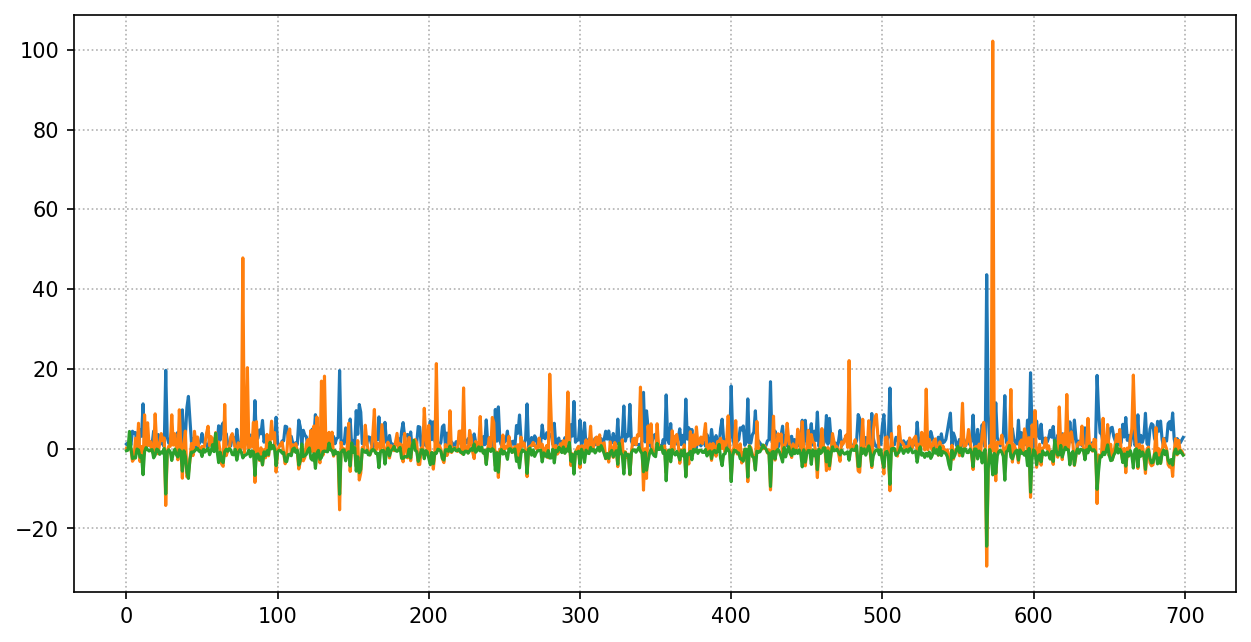

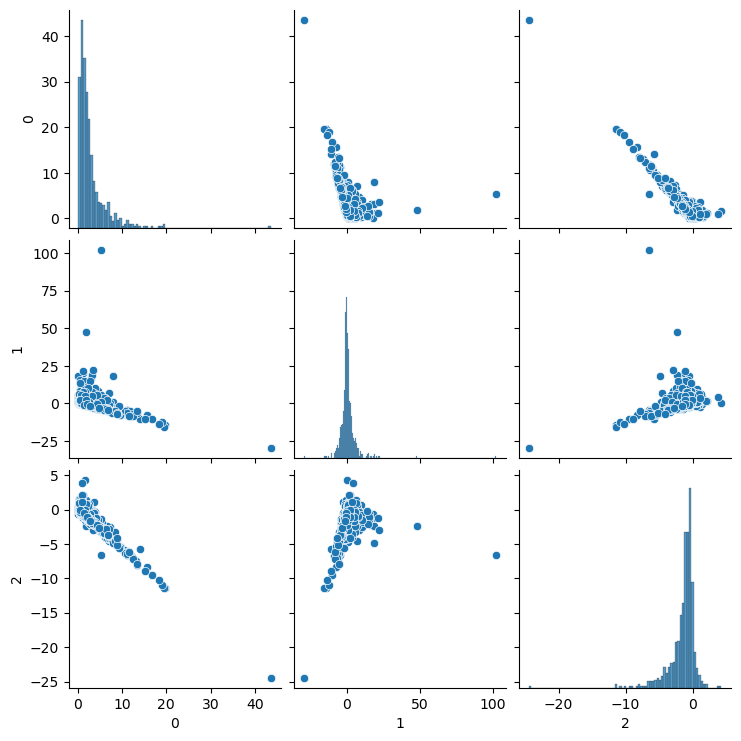

In [4]:
import pandas as pd

# Plot
if 1:
    plt.figure(figsize = (10, 5), dpi =150)
    plt.plot(X0)
    plt.grid(linestyle = ':')
    plt.show()

    sns.pairplot(pd.DataFrame(X0))
    plt.show()

#### **2. Perform scaler**

**Since PCA is scale-sensitive in its range, scaler should be applied to dataset**

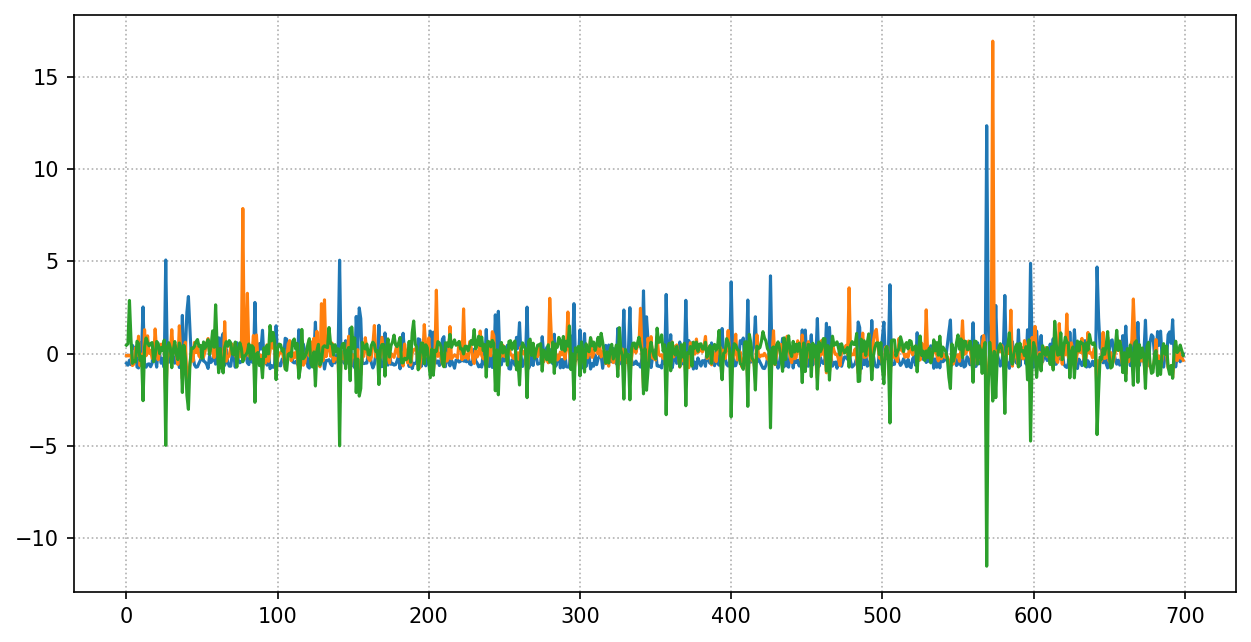

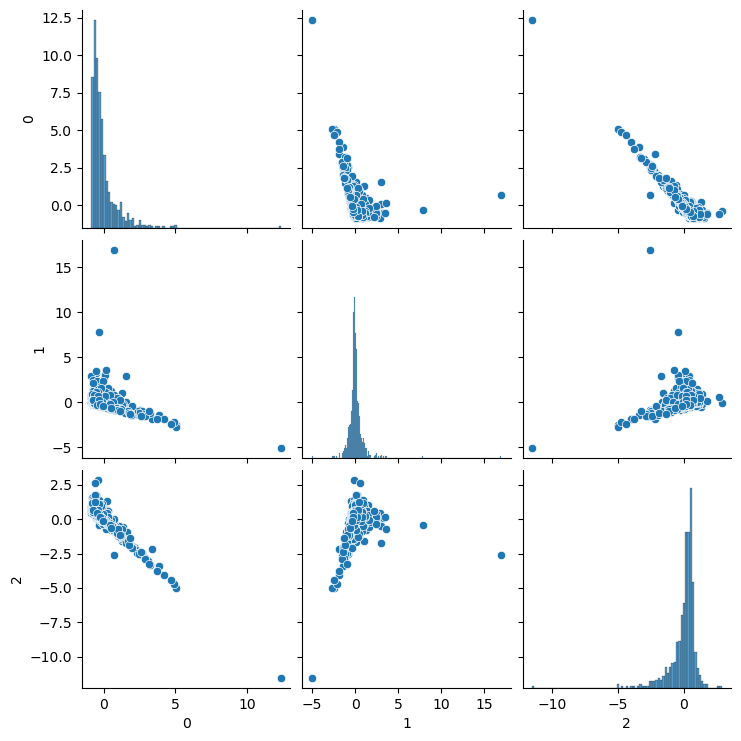

In [5]:
# Define standardizer (scaling)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X0)

# Get samples from baseline (Normal data)
if 1:
    plt.figure(figsize = (10, 5), dpi =150)
    plt.plot(X_scaled)
    plt.grid(linestyle = ':')
    plt.show()

    sns.pairplot(pd.DataFrame(X_scaled))
    plt.show()

#### **3. Define anomaly detection model: PCA**

**Define helper-function for Anomaly detection based-on PCA**

In [6]:
from sklearn.decomposition import PCA

def perform_PCA_given_data(X):
    '''
        - Input
            X : Normalzied training samples [N(# samples)-by-f(# features)]

        - Output
            pca: fitted PCA model
            explVar: exaplined variance for PCs
            V: principal compoent vectors
            n_comp: # retained PCs
    '''
    pca = PCA().fit(X)

    # Explained variance of each features for PCA
    S = pca.explained_variance_
    
    # Retained PCs
    V = pca.components_

    return pca, S, V

pca, S, V = perform_PCA_given_data(X_scaled)

**Plot exlained PCs**

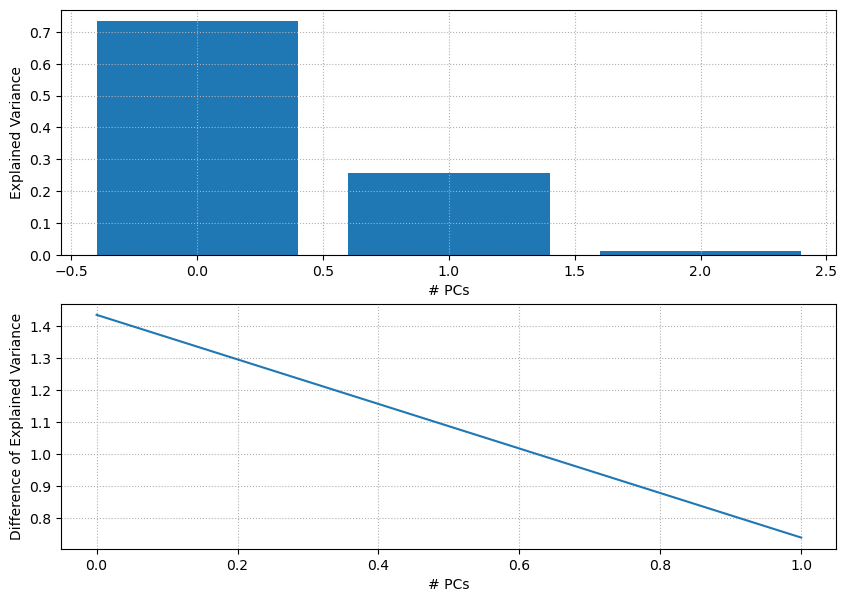

In [7]:
fig, ax = plt.subplots(2, 1, figsize = (10, 7))
# ax[0].bar(np.arange(0, S.shape[0]), S)
ax[0].bar(np.arange(0, S.shape[0]), S / sum(S))
ax[0].set_xlabel('# PCs')
ax[0].set_ylabel('Explained Variance')
ax[0].grid(linestyle = ':')


ax[1].plot(np.arange(0, S.shape[0]-1), np.abs(np.diff(S)))
# ax[1].plot(n_comp, np.abs(np.diff(S))[n_comp], 'bo', label = 'Optimal # PC')
ax[1].set_xlabel('# PCs')
ax[1].set_ylabel('Difference of Explained Variance')
ax[1].grid(linestyle = ':')
plt.show()

**Select optimal # of PCs: eigengap technique**

> **Ref.1) The rotation of eigenvectors by a perturbation (1970)**
> 
> **Ref.2) Adaptive data-derived anomaly detection in the activated... (2016)**

In [8]:
# Ref. 2)
n_comp = np.argmax(np.abs(np.diff(S))) + 1
n_comp

1

#### **Evaluation Step (Monitoring Phase)**

#### **1. Q-Statistic**
Q- residual indicates how well each sample conforms to the PCA model. 
- It is a measure of the difference, or residual between a sample and its projection into the principal components retained in the model.

$$
    Q(X, P_{1:r}) = X(I - P_{1:r}P_{1:r}^T)X^T = \| X - \hat{X} \|^2
$$

where $\hat{X} = P_{1:r} X$
- X: Normalized X
- P: Principal component (PC) vectors
- r: # of retained PCs

*Compute Q-Statistics*

In [9]:
# V[:n_comp]
def compute_Q_statistics(X, V_comp):    
    Q = np.sqrt(np.sum((X - np.matmul(np.matmul(X, V_comp.T), V_comp))**2, axis = 1))
    
    return Q

*Compute threshold of Q-Statistics*

$$
    Q_{alpha} = \frac{\theta_2}{2 \theta_1}\chi_{\alpha}^2(h)
$$

where 
- $\theta_1$: sample mean
- $\theta_2$: sample variance
- $\chi_{\alpha}^2(h)$: chi-squared distribution with $h$ degree of freedom and the significance level $\alpha$
- $h = \frac{2\theta_1^2}{\theta_2}$

> Note it is based on normality assumption on Q-statistics

In [10]:
from scipy.stats.distributions import chi2

def compute_Q_statistics_via_assumption(Q, alpha = 0.95):
    theta1 = np.mean(Q)
    theta2 = np.var(Q)
    h = 2 * (theta1 ** 2) / theta2
    chi_h = chi2.ppf(alpha, df=h)
    Qlimit = theta2/(2*theta1) * chi_h
    
    return Qlimit

- Conformal prediction => stoppting criteria => based on significance level (alpha)

#### **1) Previous approach via Gaussian residual assumption**

In [11]:
Q_previous = compute_Q_statistics(X_scaled, V[:n_comp])
Qlim_previous = compute_Q_statistics_via_assumption(Q_previous, alpha)

#### **2) Proposed method via data-centric learning using conformal prediction**

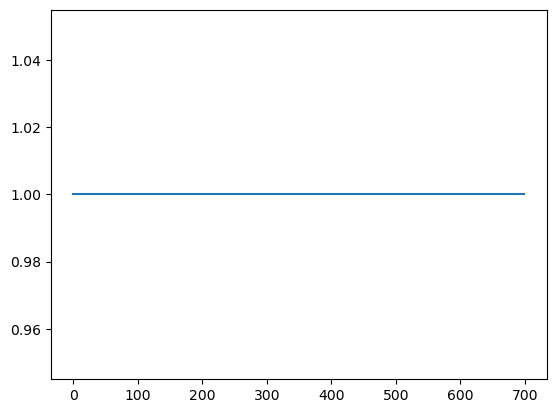

In [12]:
def Automatic_threshold_via_Data_centric_learning(X_scaled):
    Q_proposed, n_comp_list = [], []

    for i in range(X_scaled.shape[0]):
        # Leave-one-out sampling
        Xtrain_subset = np.delete(X_scaled, i, axis=0)
        X_loo = X_scaled[i, :].reshape(1, -1)

        # fit PCA for given subset
        pca, S, V = perform_PCA_given_data(Xtrain_subset)

        # eigengap technique for calculating # of PCs
        n_comp = np.argmax(np.abs(np.diff(S))) + 1        

        # Compute Q-Statistics of Q_LOOCV
        Q_loo = compute_Q_statistics(X_loo, V[:n_comp])

        # Append Q-statistics
        Q_proposed.append(Q_loo)
        n_comp_list.append(n_comp)

    return np.array(Q_proposed), np.array(n_comp_list)

Q_proposed, n_comp_list = Automatic_threshold_via_Data_centric_learning(X_scaled)

plt.plot(n_comp_list)
plt.show()

In [13]:
def summary_and_plot_result(Q, Qlim, title_string, alpha):
    coverage_previous = (Q < Qlim).sum()/Q.shape[0]*100
    
    plt.figure(figsize = (10, 3), dpi = 200)
    x = np.arange(0, Q.shape[0])
    plt.plot(x, Q, '.')
    outliers = Q >= Qlim
    plt.plot(x[outliers], Q[outliers], 'r.')
    a = plt.axhline(Qlim, color = 'r', linestyle = '-', label = f"Qlim: {Qlim:.3f}")
    plt.grid(linestyle = ':')
    plt.xlabel(f"Coverage (%): {coverage_previous:.2f} ({outliers.sum()}/{Q.shape[0]}*100)")
    plt.legend()
    plt.title(title_string + f" (alpha = {alpha})")
    plt.show()

    print(f"Coverage (%): {coverage_previous} ({outliers.sum()}/{Q.shape[0]}*100)")

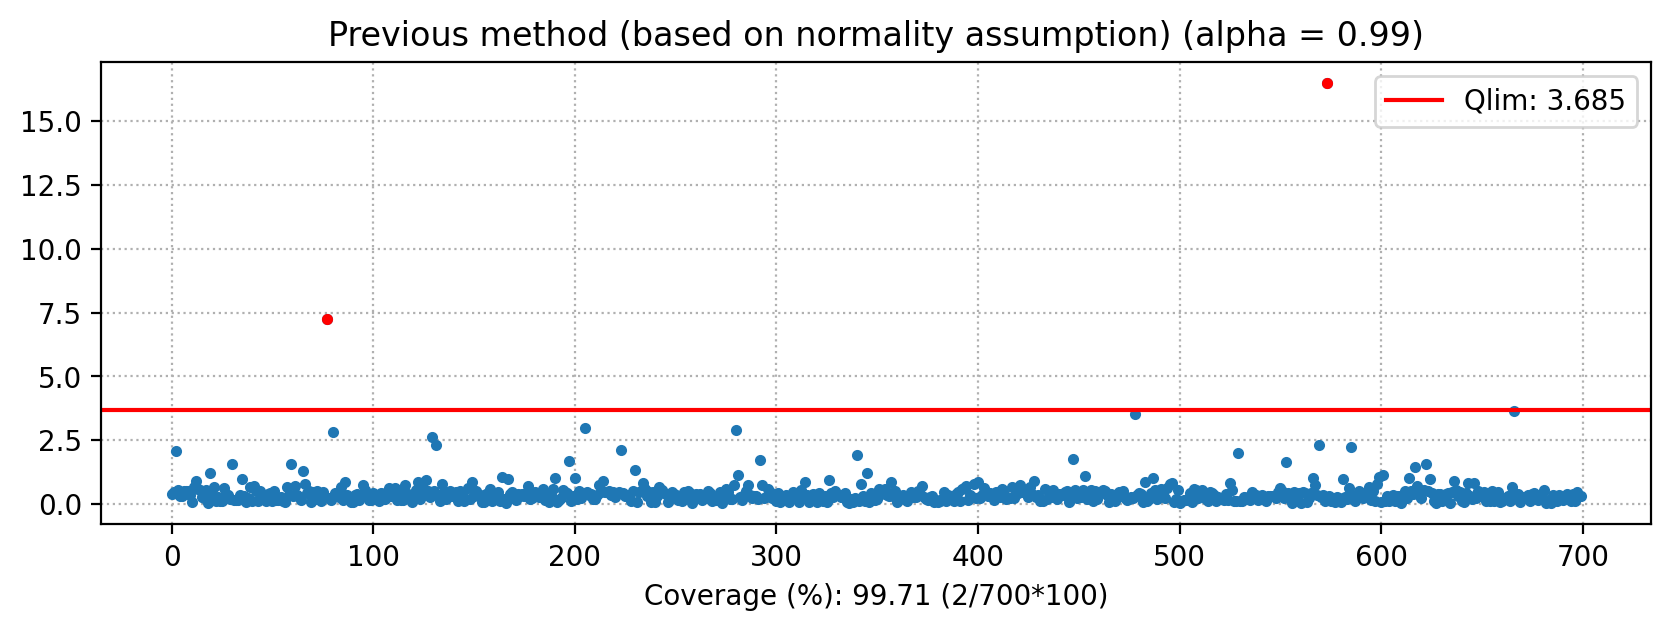

Coverage (%): 99.71428571428571 (2/700*100)


In [14]:
title_string='Previous method (based on normality assumption)'
summary_and_plot_result(Q_previous, Qlim_previous, title_string, alpha)

In [15]:
# Qlim_empirical = np.quantile(Q_previous, alpha, method="higher")

# title_string = 'Previous method (based on empirical residuals)'
# summary_and_plot_result(Q_previous, Qlim_empirical, title_string, alpha)

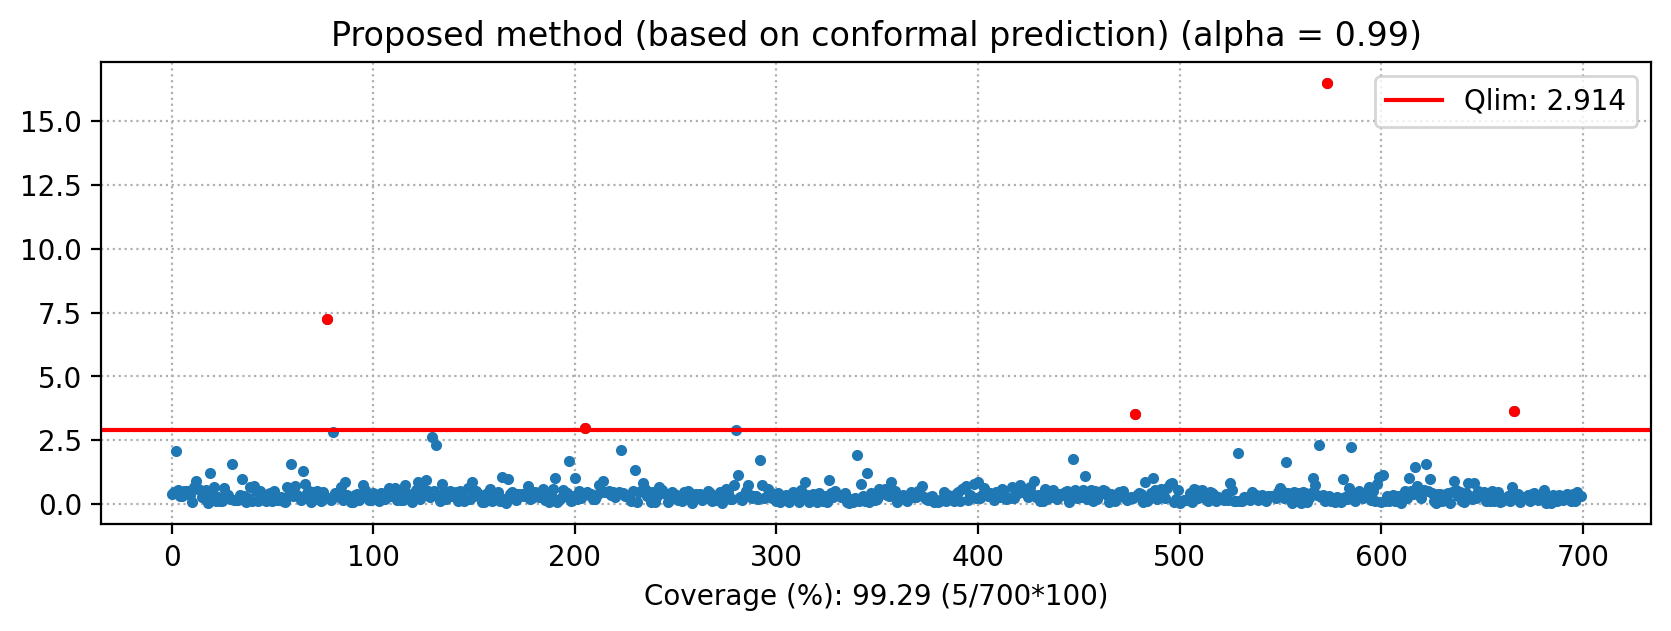

Coverage (%): 99.28571428571429 (5/700*100)


In [16]:
emperical_quantile = alpha * (1 + (1 / Q_proposed.shape[0]))
Qlim_proposed = np.quantile(Q_proposed, emperical_quantile, method="higher")

title_string='Proposed method (based on conformal prediction)'
summary_and_plot_result(Q_previous, Qlim_proposed, title_string, alpha)